In [0]:
#Dataseti çekmek için Drive a bağlanıyoruz
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Kullanılan sınıflar
import cv2
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import SGD, Adam, Adamax, Nadam, RMSprop, Adagrad, Adadelta
from keras.callbacks import ModelCheckpoint
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential, model_from_json
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,SeparableConv2D,BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.applications.inception_v3 import preprocess_input
from keras.applications.xception import  preprocess_input    
import numpy as np
import skimage.io as io
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import itertools  
from google.colab import files

h='HuSHeM'
s='SMIDS'
#Ayarlamalar
folds=['fold1'] #['fold1', 'fold2', 'fold3','fold4','fold5']
_activations=['softplus'] #['softmax', 'softplus', 'hard-sigmoid','sigmoid']
_optimizers=['sgd'] #['adam',  'adamax','sgd']
mdl='MobileNet' #Xception-InceptionV3-MobileNet
dat=s # kullanılmak istenen dataset

augment=1
batch_size=90
epochs=10

if(dat=='s'):
  img_size=170  #HuSHeM İÇİN 131 ----SMIDS İÇİN 170
  CLASSES = 3 #Hushem için 4 SMIDS için 3
else:
  img_size=131
  CLASSES = 4

Using TensorFlow backend.


In [0]:
def one_hot_encode(labels):

# we use one hot encode method to represent the classes
    encoded = np.zeros((len(labels), CLASSES))
    for idx, val in enumerate(labels):
        encoded[idx][val] = 1
    return encoded

In [0]:
#v fold1-fold2-fold3-fold4-fold5
#type Train/Test
def data_prep(dataset,v,type):
    train_labels=[]
    image_dataset=[]
    if(dataset=='HuSHeM'):     
      foldnames=['01_Normal','02_Tapered','03_Pyriform','04_Amorphous']
      print('HuSHeM veriseti okunuyor...')
    else:
      foldnames=['Acrosome Abnormality','Boya','Sperm']
      print('SMIDS veriseti okunuyor...')
    print(foldnames)
    for j, k in enumerate(foldnames):     
      directory='/content/gdrive/My Drive/Proje/'+dataset+'/'+v+'/'+type+'/'+k
      class_names = next(os.walk(directory))
      for cs in class_names[2]:
        path=''+directory+'/'+cs
        #train_roots.append(path)
        img=io.imread(path)
        img= resize(img, (img_size, img_size,3),anti_aliasing=True)
        image_dataset.append(img)
        train_labels.append(j)
    image_dataset=np.asarray(image_dataset)
    encoded=one_hot_encode(train_labels)
    print('okudu')
    return image_dataset,encoded

In [0]:
def mdlcmp(opt,act):
  # setup model
  if(mdl=='MobileNet'):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='Xception'):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
  else:
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
  
  # transfer learning 
  x = base_model.output
  x = Flatten()(x)
  predictions = Dense(CLASSES, activation=act)(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  #Model Compile     
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc', mode='max', patience=3, verbose=1)]
  return model

In [0]:
#Data Augmentation veri çoğaltma
def datagen():
    datagen = ImageDataGenerator(
              rotation_range=20,
              zoom_range=0.15,
              width_shift_range=0.2,
              height_shift_range=0.2, 
              shear_range=0.15,
              horizontal_flip=True, 
              fill_mode="nearest")
    return datagen

In [0]:
#Model eğitimi ve sonuçların kaydedilmesi
scoreses=[]
for i, v in enumerate(folds): #fold fold data okunuyor, ['fold1', 'fold2', 'fold3','fold4','fold5']
  prnt = "'!!!!!!!!!!!!!!! FOLD-{} TRAIN !!!!!!!!!!!!!!!!!!!'" 
  #Data hazırlanıyor   
  train,train_label=data_prep(dat,v,'train')
  test,test_label=data_prep(dat,v,'test')
  #Activasion ve optimizerlar değştirilerek model sonuçları elde ediliyor
  for k, a in enumerate(_activations): #11 tane aktivasyon parametresi,['softmax', 'softplus', 'hard-sigmoid','sigmoid']
    for j, o in enumerate(_optimizers): #7 tane optimizer parametresi,'rmsprop','adagrad', 'nadam','adadelta' 'adam','adamax',
      print(a,o,prnt.format(v)) 
      #Model compile ediliyor 
      model=mdlcmp(o,a)    
      #Data augmentation yapılıyor
      aug=datagen()
      epoch_step = ((len(train) *  augment) // batch_size) + 1
      print('Steps per epoch:',epoch_step,' Train length:',len(train))
      #Model EĞİTİLİYOR
      history = model.fit_generator(aug.flow(train, train_label, batch_size=batch_size),
                                    steps_per_epoch=epoch_step,
                                    epochs=epochs)                             
      #Model sonuçları test ediliyor
      print(a,o,'TestFold {',i+1,'}')
      scores = model.evaluate(test,test_label, verbose=1)
      print('Test loss:', scores[0])
      print('Test accuracy:', scores[1],'\n')
      #Sonuçlar kaydediliyor
      scoreses.append(scores) 
         

SMIDS veriseti okunuyor...
['Acrosome Abnormality', 'Boya', 'Sperm']
okudu
SMIDS veriseti okunuyor...
['Acrosome Abnormality', 'Boya', 'Sperm']
okudu
softplus sgd '!!!!!!!!!!!!!!! FOLD-fold1 TRAIN !!!!!!!!!!!!!!!!!!!'








/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '







17227776/17225924 [==============================] - 2s 0us/step


Steps per epoch: 27  Train length: 2405
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
27/27 [==============================] - 18s 670ms/step - loss: 0.9406 - acc: 0.6628
Epoch 2/10
27/27 [==============================] - 14s 522ms/step - loss: 0.5465 - acc: 0.7966
Epoch 3/10
27/27 [==============================] - 14s 528ms/step - loss: 0.4614 - acc: 0.8143
Epoch 4/10
27/27 [==============================] - 14s 524ms/step - loss: 0.3986 - acc: 0.8487
Epoch 5/10
27/27 [==============================] - 14s 525ms/step - loss: 0.3826 - acc: 0.8478
Epoch 6/10
27/27 [==============================] - 14s 517ms/step - loss: 0.3566 - acc: 0.8577
Epoch 7/10
27/27 [==============================] - 14s 524ms/step - loss: 0.3216 - acc: 0.8655
Epoch 8/10
27/27 [==============================] - 14s 523ms/step - loss: 0.3230 - acc: 0.8800
Epoch 9/10
27/27 [======

In [0]:
#Eğitilen modellerin sonuçları
scoreses

[[0.31944189707438153, 0.8849999992052714]]

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

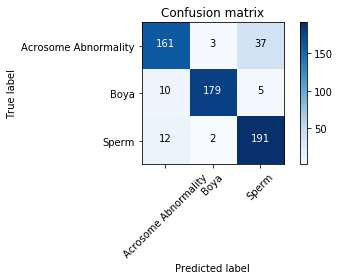

In [0]:
if(dat=='s'):
  class_names=['Acrosome Abnormality','Boya','Sperm'] #['01_Normal','02_Tapered','03_Pyriform','04_Amorphous'] 
else:
  class_names=['01_Normal','02_Tapered','03_Pyriform','04_Amorphous'] 
  
pred = model.predict(test,verbose=0)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(test_label,axis=1)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,classes=class_names,
                       normalize=False,
                       title='Confusion matrix', cmap=plt.cm.Blues)

In [0]:
#Modeli arayüzde kullanmak için diske kaydedip indiriyoruz
model_json = model.to_json()
with open('mobil.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
save_location ="Mobil_Hushem.h5"
model.save_weights(save_location)
print("Saved model to disk")

Saved model to disk
